In [1]:
%matplotlib inline
import numpy
import pandas as pd
import numba
from inventoryManagement import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
#Import data
currentInventoryState = pd.read_csv('inputATDataForMC.csv')
vendorStats = pd.read_csv('currentStatsAT.csv')
currentInventoryState = currentInventoryState.loc[(currentInventoryState['Unit Cost'] > 0.0001) & (currentInventoryState['Total Usage'] > 0.6)]

#Pick off data for monte-carlo
numParts = len(currentInventoryState)
baseData = np.empty((numParts, 8))
baseData[:,0] = range(numParts)
baseData[:,1] = currentInventoryState['Unit Cost'].values
baseData[:,2] = currentInventoryState['Total Usage']/365.0
baseData[:,3] = currentInventoryState['Total Usage']/365.0*currentInventoryState['Lead Time (days)']
baseData[:,4] = currentInventoryState['Unit Cost']*currentInventoryState['Total Usage']
baseData[:,4] /= baseData[:,4].sum()
baseData[:,5] = currentInventoryState['Total Usage']/currentInventoryState['Total Usage'].sum()
baseData[:,6] = 1.0/numParts
baseData[:,7] = np.sqrt(baseData[:,3])

print "Imported data for %d parts" % numParts

Imported data for 151 parts


### Run Monte-Carlo on r, Q

In [3]:
@numba.jit
def generateCases(baseData, numTrials, cases):
    numParts = len(baseData)
    for i in range(numParts):
        cases[i,:,0] = np.random.randint(int(max(0, np.floor(baseData[i,3] - 2.5*baseData[i,7]))), \
                                         int(max(1, np.ceil(baseData[i,3] + 2.5*baseData[i,7]))), \
                                         numTrials)

        cases[i,:,1] = np.random.randint(1, int(max(2, 3*baseData[i,3])), numTrials)

@numba.jit
def evaluateCases(baseData, cases, results, summary, iForWeighting):
    global flipped
    step = cases.shape[0]/20
    for i in range(cases.shape[0]):
        #Print status
        if i%step == 0:
            print "%d percent complete" % (float(i)*100/cases.shape[0])
        #Calculate inventory metrics
        for j in range(cases.shape[1]):
            results[i,j,0] = GPoisson(cases[i,j,0], baseData[i,3])
            summary[j,0] += results[i,j,0]*baseData[i,iForWeighting]
            results[i,j,1] = min(1,SPoisson(cases[i,j,1], cases[i,j,0], baseData[i,3]))
            summary[j,1] += results[i,j,1]*baseData[i,iForWeighting]
            results[i,j,2] = BPoisson(cases[i,j,1], cases[i,j,0], baseData[i,3])
            summary[j,2] += results[i,j,2]*baseData[i,iForWeighting]
            results[i,j,3] = IPoisson(cases[i,j,1], cases[i,j,0], baseData[i,3], results[i,j,2])
            summary[j,3] += results[i,j,3]*baseData[i,1]
            summary[j,4] += baseData[i,2]*365.0/cases[i,j,1]*baseData[i,iForWeighting]

@numba.jit
def recalculateSummary(baseData, cases, results, summary, iForWeighting):
    for i in range(cases.shape[0]):
        for j in range(cases.shape[1]):
            summary[j,0] += results[i,j,0]*baseData[i,iForWeighting]
            summary[j,1] += results[i,j,1]*baseData[i,iForWeighting]
            summary[j,2] += results[i,j,2]*baseData[i,iForWeighting]
            summary[j,3] += results[i,j,3]*baseData[i,1]
            summary[j,4] += baseData[i,2]*365.0/cases[i,j,1]*baseData[i,iForWeighting]
                 
def evaluateCasesLowMem(baseData, cases, results):
    raise NotImplementedError
                

In [4]:
numTrials = 1000000
# 4=Sales Volume, 5=Units Volume, 6=Unweighted
iForAvgWeighting = 4
cases = np.empty((numParts, numTrials,2))

generateCases(baseData, numTrials, cases)
results = np.empty((numParts, numTrials, 4))
summary = np.zeros((numTrials, 5))

evaluateCases(baseData, cases, results, summary, iForAvgWeighting)

#np.save('r-Q_cases2', cases)
#np.save('r-Q_results2', results)
#np.save('r-Q_summary2', summary)

summarySW = np.zeros((numTrials, 5))
recalculateSummary(baseData, cases, results, summarySW, 4)
summaryVW = np.zeros((numTrials, 5))
recalculateSummary(baseData, cases, results, summaryVW, 5)
summaryUW = np.zeros((numTrials, 5))
recalculateSummary(baseData, cases, results, summaryUW, 6)

0 percent complete

4 percent complete

9 percent complete

13 percent complete

18 percent complete

23 percent complete

27 percent complete

32 percent complete

37 percent complete

41 percent complete

46 percent complete

50 percent complete

55 percent complete

60 percent complete

64 percent complete

69 percent complete

74 percent complete

78 percent complete

83 percent complete

88 percent complete

92 percent complete

97 percent complete



/home/bl/anaconda2/lib/python2.7/site-packages/numba/dataflow.py:297: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


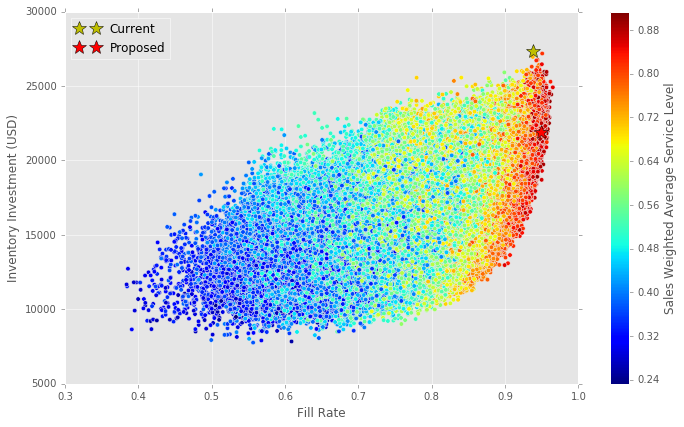

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(summarySW[:,1],summarySW[:,3], c=summarySW[:,0], marker='o')
plt.plot(0.938, 27372.61, 'y*', markersize=15.0, label='Current')
plt.plot(0.949, 21897.81, 'r*', markersize=15.0, label='Proposed')
plt.grid(True)
plt.xlabel('Fill Rate')
plt.ylabel('Inventory Investment (USD)')
plt.colorbar(label='Sales Weighted Average Service Level')
#plt.title('Performance of Inventory Management Policies')
plt.legend(loc=2)
plt.tight_layout()
plt.savefig('I_Investment_vs_FR.png', dpi=200)

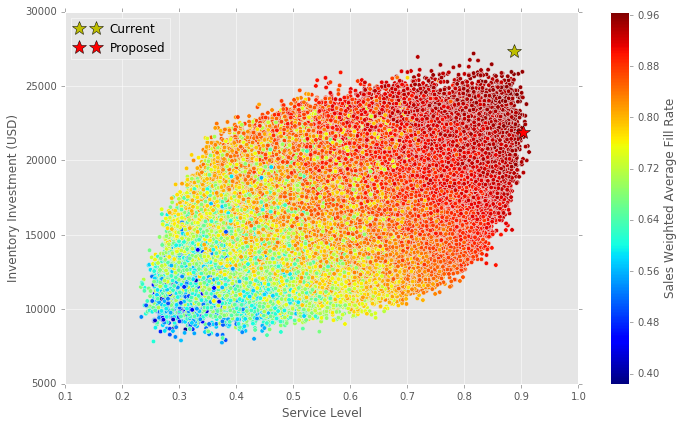

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(summarySW[:,0],summarySW[:,3], c=summarySW[:,1], marker='o')
plt.plot(0.887, 27372.61, 'y*', markersize=15.0, label='Current')
plt.plot(0.903, 21897.81, 'r*', markersize=15.0, label='Proposed')
plt.grid(True)
plt.xlabel('Service Level')
plt.ylabel('Inventory Investment (USD)')
plt.colorbar(label='Sales Weighted Average Fill Rate')
#plt.title('Performance of Inventory Management Policies')
plt.legend(loc=2)
plt.tight_layout()
plt.savefig('I_Investment_vs_SL.png', dpi=200)

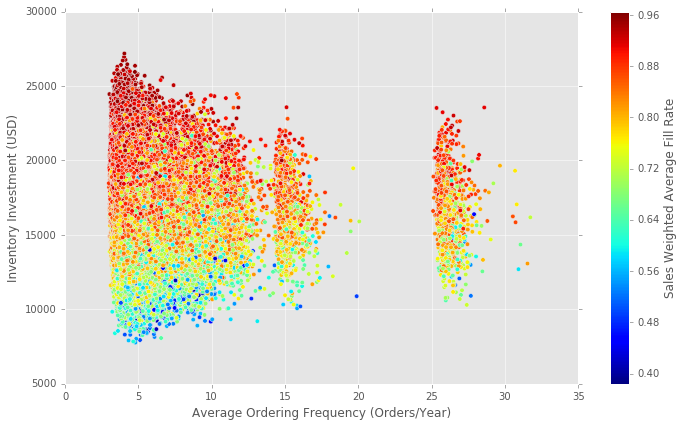

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(summaryUW[:,4],summarySW[:,3], c=summarySW[:,1], marker='o')
plt.grid(True)
plt.xlabel('Average Ordering Frequency (Orders/Year)')
plt.ylabel('Inventory Investment (USD)')
#plt.xlim(0,20)
plt.colorbar(label='Sales Weighted Average Fill Rate')
#plt.title('Performance of Inventory Management Policies')
plt.tight_layout()
plt.savefig('I_Investment_vs_Ordering_Freq.png', dpi=200)

In [13]:
maxInvest = 21890
minFillRate = 0.9

numValidCases = 0

for i in range(summarySW.shape[0]):
    if (summarySW[i,1] > minFillRate) and (summarySW[i,3] < maxInvest):
        numValidCases += 1
        

summaryValidSW = np.zeros((numValidCases, 5))
summaryValidVW = np.zeros((numValidCases, 5))
summaryValidUW = np.zeros((numValidCases, 5))
summaryNotValidSW = np.zeros((numTrials - numValidCases, 5))
summaryNotValidVW = np.zeros((numTrials - numValidCases, 5))
summaryNotValidUW = np.zeros((numTrials - numValidCases, 5))

i_valid = 0
i_notValid = 0
for i in range(summarySW.shape[0]):
    if (summarySW[i,1] > minFillRate) and (summarySW[i,3] < maxInvest):
        summaryValidSW[i_valid] = summarySW[i]
        summaryValidVW[i_valid] = summaryVW[i]
        summaryValidUW[i_valid] = summaryUW[i]
        i_valid += 1
    else:
        summaryNotValidSW[i_notValid,:] = summarySW[i,:]
        summaryNotValidVW[i_notValid,:] = summaryVW[i,:]
        summaryNotValidUW[i_notValid,:] = summaryUW[i,:]
        i_notValid += 1


In [14]:
i_valid

89913

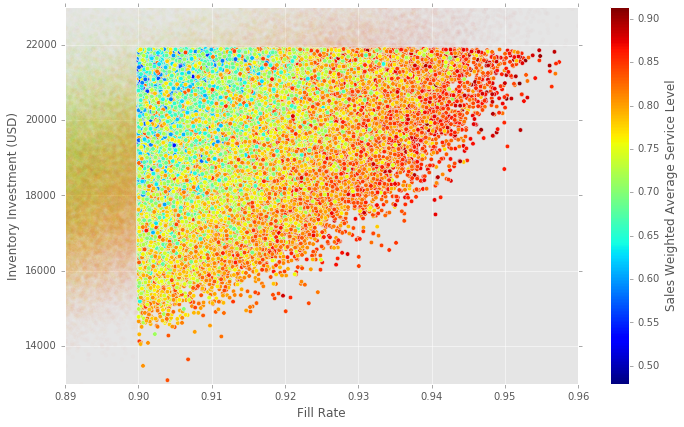

In [15]:
plt.figure(figsize=(10,6))
plt.scatter(summaryNotValidSW[:,1],summaryNotValidSW[:,3], c=summaryNotValidSW[:,0], marker='o', alpha=0.01)
plt.scatter(summaryValidSW[:,1],summaryValidSW[:,3], c=summaryValidSW[:,0], marker='o')
plt.grid(True)
plt.xlim(0.89, 0.96)
plt.ylim(13000, 23000)
plt.xlabel('Fill Rate')
plt.ylabel('Inventory Investment (USD)')
plt.colorbar(label='Sales Weighted Average Service Level')
#plt.title("Inventory Management Policies Which Meet A&T's Performance Metrics")
plt.tight_layout()
plt.savefig('I_Investment_vs_FR_ValidCases.png', dpi=200)